<a href="https://colab.research.google.com/github/ProgrammPath/exposiciones/blob/CANACO/indicador_rezago_social.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

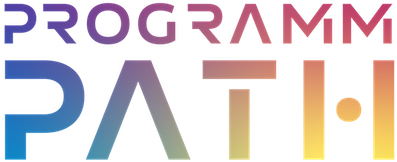

# Contexto

El presente documento es el código en Python construido para la exposición **Indicador de Rezago Social del Centro, Tabasco mediante IA** presentada en el [Ecosistema Emprendedor](https://www.jovenesempresariostab.com/eventos) llevada a cabo por la [Comisión de Jóvenes Empresarios de Tabasco](https://www.jovenesempresariostab.com/) celebrada en los días 18 y 19 de septiembre del 2024.

# Objetivo

El objetivo es mostrar a la audiencia presente en el evento anteriormente mencionado que es posible realizar un análisis de datos de la localidad en la que se habita de tal manera que se pueda evidenciar las áreas de oportunidad presentes a través de la creación de un Indicador de Rezago Social para que así las instituciones correspondientes, y en la misma medida, la responsabilidad civil se unan para construir un mejor estado.

# Datos

Se utilizan como datos los resultados del INEGI a nivel AGEB de sus diferentes métricas disponible en el siguiente link: [SCITEL](https://www.inegi.org.mx/app/scitel/Default?ev=10)

A continuación enlistamos los indicadores que se utilizan para este análisis, considerando que **este estudio se realiza con fines divulgativos y didácticos** más que confines de una aplicación real es que se omitirán diversas métricas pero esto no significa que no sean aplicables según el contexto que se desee estudiar.

* `Población de 8 a 14 años que no sabe leer y escribir` (P8A14AN)
* `Población de 15 años y más analfabeta` (P15YM_AN)
* `Población de 15 años y más sin escolaridad` (P15YM_SE)
* `Población de 12 años y más económicamente activa` (PEA)
* `Población sin afiliación a servicios de salud` (PSINDER)
* `Viviendas particulares habitadas con piso de tierra` (VPH_PISOTI)
* `Viviendas particulares habitadas que no disponen de energía eléctrica` (VPH_S_ELEC)
* `Viviendas particulares que no disponen de agua entubada en el ámbito de la vivienda` (VPH_AGUAFV)
* `Viviendas particulares habitadas que no disponen de drenaje` (VPH_NODREN)
* `Viviendas particulares habitadas que no disponen de automóvil o camioneta, ni de motocicleta o motoneta` (VPH_NDACMM)
* `Viviendas particulares habitadas sin ningún bien` (VPH_SNBIEN)
* `Viviendas particulares habitadas sin tecnologías de la información y de la comunicación (TIC)` (VPH_SINTIC)

Los indicadores a utilizar se describen en el siguiente documento: [Descripción indicadores](https://www.inegi.org.mx/app/scitel/doc/descriptor/fd_agebmza_urbana_cpv2020.pdf)

# Paqueterías

Considerando que este documento se escribe a través de [Google COLAB](https://colab.research.google.com/), la instalación de la paquetería `INEGIpy` se tiene que realizar cada vez que se conecte a los servidores de Google.

Se anexa el link del GitHub de la paquetería INEGIpy: [GitHub INEGIpy](https://github.com/andreslomeliv/DatosMex/tree/master/INEGIpy)

In [ ]:
!pip install INEGIpy
!pip install factor_analyzer

from factor_analyzer.factor_analyzer import calculate_kmo
import requests, zipfile, io
import pandas as pd
import numpy as np
from INEGIpy import MarcoGeoestadistico
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import KMeans

token = "TOKEN_INEGI"

El uso de los datos del INEGI requiere de un TOKEN, el cual se puede conseguir en el siguiente link:

[Generador de TOKEN](https://www.inegi.org.mx/app/desarrolladores/generatoken/Usuarios/token_Verify)

# Limpieza de datos

A continuación realizamos la importación, filtrado y limpieza de datos.

In [ ]:
########

# Extraemos la informacion del INEGI para obtener los datos geometricos
# de los AGEB de Tabasco

marco = MarcoGeoestadistico()
ageb = marco.AGEBs(entidades=["27"])
ageb = ageb[ageb["cve_agem"]=='004'].reset_index(drop=True)

########

######## ########

# Extraemos la informacion a nivel AGEB de todos los indicadores solamente para Tabasco

url="https://www.inegi.org.mx/contenidos/programas/ccpv/iter/zip/resageburb20/resageburb_27csv20.zip"
filename = 'RESAGEBURB_27CSV20.csv'

r = requests.get(url)
z = zipfile.ZipFile(io.BytesIO(r.content))
z.extractall()

data = pd.read_csv(filename).replace('*',np.nan)

######## ########

######## ######## ########

# Realizamos una limpieza de los datos

data = data[(data["NOM_MUN"]=="Centro")]
data = data[~data["NOM_LOC"].isin(['Total del municipio', 'Total de la localidad urbana','Total AGEB urbana'])].reset_index(drop=True)

lista = list()
for loc in data.LOC:
    if len(str(loc)) == 1:
        lista.append( "000"+str(loc) )
    elif len(str(loc)) == 2:
        lista.append( "00"+str(loc) )
    elif len(str(loc)) == 3:
        lista.append( "0"+str(loc) )
    else:
        lista.append( str(loc) )

data["LOC"] = lista
data["MUN"] = "004"
data["ENTIDAD"] = data["ENTIDAD"].astype(str)
data.insert( 8, "cvegeo", data["ENTIDAD"]+data["MUN"]+data["LOC"]+data["AGEB"] )

for indicador in data.loc[:,"POBTOT":].columns:
    data[indicador] = data[indicador].astype(float)

# Se realiza una agrupacion pues los datos estan a nivel manzana

data = data.loc[:,["NOM_ENT","NOM_MUN","NOM_LOC","cvegeo"]+["P8A14AN","P15YM_AN","P15YM_SE","PEA","PSINDER","VPH_PISOTI","VPH_S_ELEC",
 "VPH_AGUAFV","VPH_NODREN","VPH_NDACMM","VPH_SNBIEN","VPH_SINTIC"]].groupby(by=["NOM_ENT","NOM_MUN","NOM_LOC","cvegeo"]).sum().reset_index()

# Se une la informacion con los datos geometricos

data = data.merge( right = ageb[["cvegeo","geometry"]],
            how = "left",
            left_on = "cvegeo",
            right_on = "cvegeo")
data.head()

######## ######## ########

,NOM_ENT,NOM_MUN,NOM_LOC,cvegeo,P8A14AN,P15YM_AN,P15YM_SE,PEA,PSINDER,VPH_PISOTI,VPH_S_ELEC,VPH_AGUAFV,VPH_NODREN,VPH_NDACMM,VPH_SNBIEN,VPH_SINTIC,geometry
0,Tabasco,Centro,Acachapan y Colmena 1ra. Sección,2700400190352,3.0,92.0,73.0,1751.0,1009.0,27.0,0.0,127.0,4.0,635.0,6.0,12.0,None
1,Tabasco,Centro,Anacleto Canabal 1ra. Sección,2700400330386,6.0,97.0,103.0,2194.0,1461.0,12.0,0.0,0.0,4.0,715.0,0.0,0.0,None
2,Tabasco,Centro,Anacleto Canabal 2da. Sección,2700400341810,13.0,192.0,210.0,2534.0,2253.0,23.0,4.0,26.0,3.0,988.0,9.0,26.0,"MULTIPOLYGON (((-93.01360 17.98098, -93.01505 ..."
3,Tabasco,Centro,Anacleto Canabal 2da. Sección,2700400342503,0.0,0.0,0.0,16.0,13.0,0.0,0.0,0.0,0.0,5.0,0.0,0.0,"MULTIPOLYGON (((-93.00608 17.97034, -93.00609 ..."
4,Tabasco,Centro,Anacleto Canabal 3ra. Sección,2700400350386,4.0,72.0,69.0,5213.0,1795.0,15.0,0.0,8.0,0.0,403.0,0.0,0.0,None


De los datos anteriores observamos que existe información que no presenta una correcta unión de los datos, posiblemente por la falta de disponibilidad de estos en la base de datos del INEGI, veamos proporcionalmente cuantas conexiones existosas hay

In [ ]:
(data["geometry"]!=None).mean()*100

91.62011173184358

Con el resultado anterior podemos concluir que el 91.6 % de los AGEB a estudiar sí presentan una geometría por lo que podemos descartar a los AGEB que no presentan geometrías y no estaríamos afectando a un gran porcentaje de los datos.

In [ ]:
data = data[data["geometry"]!=None].reset_index(drop=True)
data.head()

,NOM_ENT,NOM_MUN,NOM_LOC,cvegeo,P8A14AN,P15YM_AN,P15YM_SE,PEA,PSINDER,VPH_PISOTI,VPH_S_ELEC,VPH_AGUAFV,VPH_NODREN,VPH_NDACMM,VPH_SNBIEN,VPH_SINTIC,geometry
0,Tabasco,Centro,Anacleto Canabal 2da. Sección,2700400341810,13.0,192.0,210.0,2534.0,2253.0,23.0,4.0,26.0,3.0,988.0,9.0,26.0,"MULTIPOLYGON (((-93.01360 17.98098, -93.01505 ..."
1,Tabasco,Centro,Anacleto Canabal 2da. Sección,2700400342503,0.0,0.0,0.0,16.0,13.0,0.0,0.0,0.0,0.0,5.0,0.0,0.0,"MULTIPOLYGON (((-93.00608 17.97034, -93.00609 ..."
2,Tabasco,Centro,Bicentenario,2700403160066,28.0,116.0,124.0,1580.0,1288.0,0.0,0.0,0.0,0.0,919.0,0.0,9.0,"MULTIPOLYGON (((-92.92095 17.81504, -92.92200 ..."
3,Tabasco,Centro,Bicentenario,2700403160070,6.0,105.0,129.0,1460.0,2030.0,0.0,0.0,0.0,0.0,883.0,9.0,18.0,"MULTIPOLYGON (((-92.92095 17.81504, -92.92232 ..."
4,Tabasco,Centro,Buena Vista 1ra. Sección,2700400611717,9.0,106.0,41.0,1470.0,1109.0,24.0,0.0,0.0,0.0,613.0,8.0,10.0,"MULTIPOLYGON (((-92.74706 18.14325, -92.74722 ..."


Veamos el número de filas en el DataFrame anterior

In [ ]:
data.shape

(164, 17)

Por lo tanto contamos con 164 AGEBs para analizar en el municipio del Centro, Tabasco.

# Análisis de Datos

En primera instancia, realizaremos un breve análisis de los datos antes de proceder con la creación del Indicador de Rezago Social.

## Coeficiente de dispersión

Primero, estudiaremos el coeficiente de dispersión para cada variable el cual es una medida de dispersión relativa e independiente

$$CV=\frac{\sigma}{\mu}\cdot 100$$

Estos valores representan porcentajes.

In [ ]:
100*(data.loc[:,"P8A14AN":"VPH_SINTIC"].std(ddof=0) / data.loc[:,"P8A14AN":"VPH_SINTIC"].mean())

,0
P8A14AN,210.542859
P15YM_AN,118.774618
P15YM_SE,112.237879
PEA,61.619042
PSINDER,68.437152
VPH_PISOTI,297.208479
VPH_S_ELEC,446.813243
VPH_AGUAFV,308.727207
VPH_NODREN,392.823139
VPH_NDACMM,71.920746


A medida que el coeficiente de variación disminuye, se observa una mayor homogeneidad en los datos, es decir, los datos están más concentrados alrededor del promedio.

Con ello, observamos que la mayoría de las variables presentan una homogeneidad baja (heterogeneidad alta) o dicho en otro sentido, presentan mucha variabilidad entre los datos lo que puede sugerir que existirán AGEB donde la presentación de estas carencias es nula o muy alta.

## Diagrama de caja

Analicemos mediante un diagrama de caja la distribución de las variables

In [ ]:
# La siguiente funcion nos ayuda a dar formato a los numeros
# Extraido de https://stackoverflow.com/questions/579310/formatting-long-numbers-as-strings

def human_format(num, round_to=1):
    magnitude = 0
    while abs(num) >= 1000:
        magnitude += 1
        num = round(num / 1000.0, round_to)
    return '{:.{}f}{}'.format(num, round_to, ['', 'K', 'M', 'G', 'T', 'P'][magnitude])

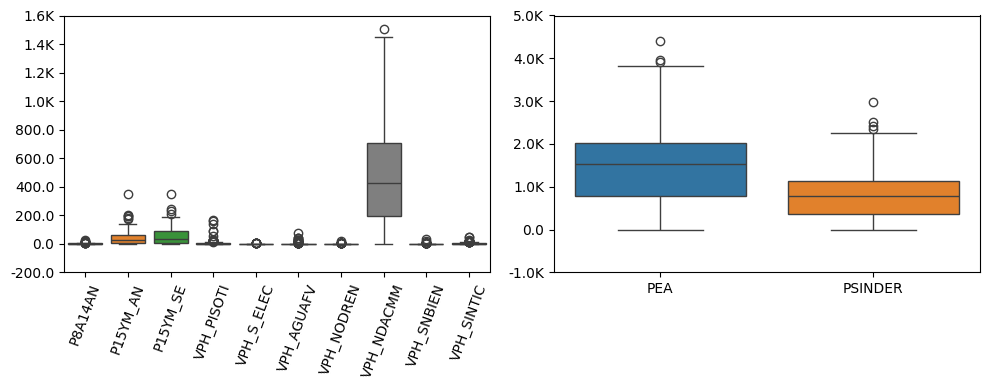

In [ ]:
fig,axs = plt.subplots(ncols=2,nrows=1,figsize=(10,4))

sns.boxplot(data.loc[:,['P8A14AN', 'P15YM_AN', 'P15YM_SE', 'VPH_PISOTI',
       'VPH_S_ELEC', 'VPH_AGUAFV', 'VPH_NODREN', 'VPH_NDACMM', 'VPH_SNBIEN',
       'VPH_SINTIC']],
            ax=axs[0])

axs[0].set_xticks(axs[0].get_xticks(),['P8A14AN', 'P15YM_AN', 'P15YM_SE', 'VPH_PISOTI',
       'VPH_S_ELEC', 'VPH_AGUAFV', 'VPH_NODREN', 'VPH_NDACMM', 'VPH_SNBIEN',
       'VPH_SINTIC'],rotation=70)

axs[0].set_yticks( axs[0].get_yticks(), map( human_format,axs[0].get_yticks() ) )

sns.boxplot(data.loc[:,['PEA', 'PSINDER']],ax=axs[1])

axs[1].set_yticks( axs[1].get_yticks(), map( human_format,axs[1].get_yticks() ) )

plt.tight_layout()

Con lo que podemos observar notamos que en cada variable existen valores atípicos lo que nos lleva a concluir que aunque la mayoría de los AGEB siguen un patron poblacional o de viviendas en relación a los indicadores habrá AGEB que presenten poblacion o viviendas que sean atípicos o más allá de lo usual en referencia a las métricas a estudiar.

# Análisis de Componentes Principales

Realizaremos un Análisis de Componentes Principales para la agrupación de los 12 indicadores a utilizar para construir nuestra Indicador de Rezago Social.

## Validación del ACP

Primero validamos que el ACP es posible de realizar al estudiar:

* La matriz de correlación de Spearman (Coeficiente de Correlación No-Paramétrico)
* Medida de Adecuación Muestral Kaiser-Meyer-Olkin

En la variable `X` almacenamos la información a estudiar

In [ ]:
X = data.loc[:,"P8A14AN":"VPH_SINTIC"].copy()
X

,P8A14AN,P15YM_AN,P15YM_SE,PEA,PSINDER,VPH_PISOTI,VPH_S_ELEC,VPH_AGUAFV,VPH_NODREN,VPH_NDACMM,VPH_SNBIEN,VPH_SINTIC
0,13.0,192.0,210.0,2534.0,2253.0,23.0,4.0,26.0,3.0,988.0,9.0,26.0
1,0.0,0.0,0.0,16.0,13.0,0.0,0.0,0.0,0.0,5.0,0.0,0.0
2,28.0,116.0,124.0,1580.0,1288.0,0.0,0.0,0.0,0.0,919.0,0.0,9.0
3,6.0,105.0,129.0,1460.0,2030.0,0.0,0.0,0.0,0.0,883.0,9.0,18.0
4,9.0,106.0,41.0,1470.0,1109.0,24.0,0.0,0.0,0.0,613.0,8.0,10.0
...,...,...,...,...,...,...,...,...,...,...,...,...
159,0.0,24.0,32.0,1109.0,611.0,10.0,0.0,0.0,0.0,410.0,0.0,0.0
160,12.0,85.0,131.0,1507.0,1144.0,54.0,7.0,73.0,8.0,546.0,3.0,7.0
161,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
162,0.0,11.0,11.0,1672.0,893.0,3.0,0.0,0.0,0.0,267.0,0.0,0.0


Calculamos la matriz de correlación de Spearman

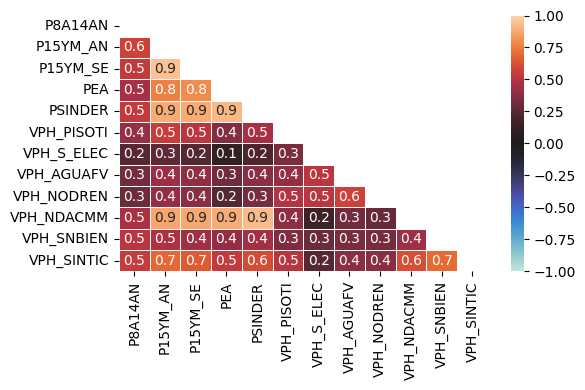

In [ ]:
plt.figure(figsize=(6,4))

correlacion = X.corr(method='spearman')

mask = np.triu(np.ones_like(correlacion))

sns.heatmap(correlacion,
            annot=True,
            fmt=".1f",
            linewidth=.5,
            vmin=-1, vmax=1,
            cmap=sns.color_palette("icefire", as_cmap=True),
            mask=mask)

plt.tight_layout()

Con la imagen anterior podemos encontrar todas las variables presentan correlación positiva, además, entre ciertas variables la correlación puede llegar a considerarse "fuerte" al tener una correlación mayor o igual a 0.8 y otras correlaciones son consideras "medias" al presentar una correlación entre 0.5 y 0.9. También existen correlaciónes "bajas" que oscilan con una correlación entre 0 y 0.4.

Lo anterior es un indicativo de que tentativamente realizar un PCA es viable, sin embargo afirmaremos esto al utilizar la **Medida de Adecuación Muestral Kaiser-Meyer-Olkin**.

El índice KMO compara los valores de las correlaciones entre las variables y sus correlaciones parciales. Si el índice está próximo a 1, el PCA se puede hacer, por el contrario si es bajo (próximo a 0), el PCA no es relevante.

Tenemos la siguiente tabla

|Valor|Clasificación|
|--|--|
| 0.9 $\geq$ KMO | **Excelente** |
| 0.8 $\leq$ KMO < 0.9 | **Bueno** |
| 0.7 $\leq$ KMO < 0.8 | **Aceptable** |
| 0.6 $\leq$ KMO < 0.7 | **Mediocre** |
| 0.5 $\leq$ KMO < 0.6 | **Malo** |
| KMO > 0.5 | **Inaceptable** |

In [ ]:
kmo_all, kmo_model = calculate_kmo(X)

print('Overall MSA = {0:.3f}'.format(kmo_model))

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.8/42.8 kB 795.3 kB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for factor_analyzer: filename=factor_analyzer-0.5.1-py2.py3-none-any.whl size=42564 sha256=d2d4e87c2575cb128332a57cd6e5db069e686eff987c030b17ee44aa12b7170b
  Stored in directory: /root/.cache/pip/wheels/24/59/82/6493618e30ed1cb7a013b9e1b0c9e17de80b04dfcef4ba8a4d
Successfully built factor_analyzer
Overall MSA = 0.860


Obteniendo un KMO general de 0.86 entramos en la categoría de **Bueno** lo que significa que los datos sí pueden agruparse de manera idónea en un PCA.

## Cálculo de valores propios y vectores propios

Los vectores propios nos permitirán crear las ecuaciones que reducen la dimensionalidad y los valores propios nos dictaminan que tanta varianza presentan, es decir:

$$z_i = \alpha_{i1}\cdot x_1 + \alpha_{i2}\cdot x_2 + \ldots + \alpha_{ip}\cdot x_p = \sum_{j} \alpha_{ij}\cdot x_j,\: \forall i$$

$$V(z_i) = \lambda_i,\: \forall i$$

A continuación para el uso de ACP usaremos la siguiente función.

Esta función nos ayuda a calcular los valores más importantes para el ACP, existe una función en Python en la paquetería `scikit-learn` y la diferencia es la aproximación de esta paquetería en los cálculos de los números.

https://scikit-learn.org/stable/modules/generated/sklearn.decomposition.PCA.html

In [ ]:
def PCA (matrix_A) :
    from numpy.linalg import eig
    import pandas as pd
    # Valores propios
    eigenval = -np.sort(-eig(matrix_A)[0])
    std = np.sqrt(eigenval)
    proportion_of_variance = (eigenval/sum(eigenval))*100
    cumulative_proportion = proportion_of_variance.cumsum()
    # Vectores propios
    index_col = np.argsort( eig(matrix_A)[0] )[::-1]
    eigenvect = -eig(matrix_A)[1]
    return pd.DataFrame({'PC{0:d}'.format(k+1):[eigenval[k],std[k],proportion_of_variance[k],cumulative_proportion[k]] for k in range(matrix_A.shape[0])},
                       index=['Variance','Standard Deviation','Proportion of Variance','Cumulative Proportion']),pd.DataFrame({'PC{0:d}'.format(j+1):eigenvect[:,c] for j,c in zip(range(matrix_A.shape[0]),index_col) },index=matrix_A.index)

Los datos a ingresar a la función es la matriz de correlación

In [ ]:
resumen_pca, vectores_propios = PCA(X.corr(method='spearman'))

La variable `resumen_pca` nos entrega la información que analizaremos para determinar el número de componentes principales y la variable `vectores_propios` nos entrega las ecuaciones de $z_i$ mencionados

## Selección del número de componentes principales

Existen diversas estrategias para la sección del número de componentes principales a utilizar, las cuales, las más comunes, son:

* Porcentaje de Variación Total Acumulada
* Tamaño de la varianza
* Método gráfico

### Porcentaje de Variación Total Acumulada

Sumar los valores propios es igual a sumar las varianzas de las variables por lo que ir sumando en partes nos irá diciendo que tanta varianza explica cada variable.

Usualmente se considera tomar el número de componentes principales que en conjunto expliquen >= 80 % de la varianza.

Observemos la tabla

In [ ]:
resumen_pca

,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,PC9,PC10,PC11,PC12
Variance,6.571891,1.741058,0.932390,0.646461,0.535809,0.470502,0.404740,0.297236,0.207560,0.089821,0.060558,0.041972
Standard Deviation,2.563570,1.319492,0.965604,0.804028,0.731990,0.685932,0.636192,0.545194,0.455588,0.299701,0.246086,0.204871
Proportion of Variance,54.765760,14.508821,7.769918,5.387175,4.465077,3.920854,3.372832,2.476967,1.729668,0.748507,0.504654,0.349768
Cumulative Proportion,54.765760,69.274581,77.044499,82.431673,86.896750,90.817604,94.190436,96.667403,98.397071,99.145578,99.650232,100.000000


Con la tabla anterior y siguiendo el criterior de porcentaje de variación total acumulada tomamos las primeras 4 columnas pues es hasta la 4ta variable donde la variación total supera el 80 %.

### Tamaño de la varianza

Esta estrategia considera tomar todas las variables cuyas varianzas sean mayores que 1. Esto tiende a incluir muy pocos componentes principales cuando el número de variables originales en estudio es menor a 20.

Observemos la tabla

In [ ]:
resumen_pca

,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,PC9,PC10,PC11,PC12
Variance,6.571891,1.741058,0.932390,0.646461,0.535809,0.470502,0.404740,0.297236,0.207560,0.089821,0.060558,0.041972
Standard Deviation,2.563570,1.319492,0.965604,0.804028,0.731990,0.685932,0.636192,0.545194,0.455588,0.299701,0.246086,0.204871
Proportion of Variance,54.765760,14.508821,7.769918,5.387175,4.465077,3.920854,3.372832,2.476967,1.729668,0.748507,0.504654,0.349768
Cumulative Proportion,54.765760,69.274581,77.044499,82.431673,86.896750,90.817604,94.190436,96.667403,98.397071,99.145578,99.650232,100.000000


Con esta aproximación solamente tomamos 2 variables, las primeras dos columnas, pues son las únicas que presentan una varianza mayor a 1.

### Método gráfico

El método gráfico consiste en dibujar las varianzas de cada componente principal y quedarse con aquellas antes del quiebre en la curva

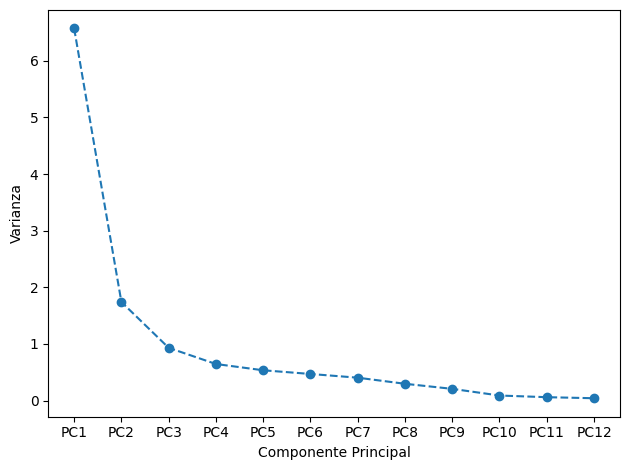

In [ ]:
plt.plot(resumen_pca.iloc[0],marker='o',ls='--')

plt.xlabel('Componente Principal')
plt.ylabel('Varianza')
plt.tight_layout()

Con el método gráfico podemos concluir que con 2 componentes principales es suficiente.

### Conclusión

Cuando analizamos el porcentaje de variación total acumulada concluimos que el número de componentes principales a tomar es 4 pues con 4 encontramos una variación total explicada del 82 %, al utilizar el criterio de Kaiser se concluye que con 2 componentes principales se puede realizar el estudio dado que con los dos primeros componentes se obtiene una varianza mayor a 1, por último en el método gráfico se visualiza que después de los 2 primeros componentes se presenta un cambio abrupto en la variabilidad y por tanto se considera con esta aproximación que dos componentes son suficientes.

Hay que considerar que agregar más variables al modelo lo vuelve más complejo y agregar menos variables lo vuelve muy simple, por tanto se considera que lo mejor para la reducción de la variabilidad sin perdida de variación explicada significativa y en consideración de los resultados en los otros métodos se procede con 3 componentes principales.

# Creación del Indicador de Rezago Social

Vamos ahora a calcular los valores que le corresponden a cada AGEB según las nuevas ecuaciones que encontramos, para ello es **importante** utilizar los datos estandarizados lo cual haremos mediante la siguiente función

In [ ]:
scale = lambda df : (df-df.mean())/df.std()

In [ ]:
X_scale = scale(X)

z_1 = vectores_propios['PC1']; z_2 = vectores_propios['PC2']
z_3 = vectores_propios['PC3']

observaciones = pd.concat([X_scale@z_1.to_frame(name='Z1'),
                           X_scale@z_2.to_frame(name='Z2'),
                           X_scale@z_3.to_frame(name='Z3')],
                          axis=1)

observaciones

,Z1,Z2,Z3
0,-7.299530,2.070192,0.806331
1,2.715939,0.914674,0.534094
2,-3.199936,-1.159043,2.247425
3,-3.083286,-1.176016,1.959169
4,-1.798926,-0.169191,2.223614
...,...,...,...
159,1.143090,-0.018088,-0.179640
160,-5.738247,8.368121,-2.497666
161,2.733867,0.928535,0.543398
162,1.210334,-0.169949,-0.222637


Vamos a crear 3 niveles para el Indicador de Rezago Social

* **Bajo**
* **Medio**
* **Alto**

Para hacer lo anterior utilizamos el algoritmo K-Means

In [ ]:
clusters = KMeans(init="k-means++",n_clusters=3,n_init=20,random_state=123).fit(observaciones.values).labels_

X['cluster_id'] = clusters
data["cluster_id"] = clusters

Observamos los resultados y damos la descripción a cada cluster creado

In [ ]:
X.groupby(by='cluster_id').mean()

,P8A14AN,P15YM_AN,P15YM_SE,PEA,PSINDER,VPH_PISOTI,VPH_S_ELEC,VPH_AGUAFV,VPH_NODREN,VPH_NDACMM,VPH_SNBIEN,VPH_SINTIC
cluster_id,,,,,,,,,,,,
0,0.373737,13.555556,16.858586,984.474747,493.121212,2.050505,0.070707,1.212121,0.101010,262.747475,0.242424,0.757576
1,3.576271,81.135593,96.694915,2357.677966,1338.593220,9.847458,0.101695,3.101695,0.627119,823.084746,1.762712,6.389831
2,10.166667,182.000000,211.166667,2895.000000,2151.000000,85.833333,4.000000,31.333333,7.500000,1088.833333,13.333333,27.333333


Al observar la información podemos concluir que

* `cluster_id` = 0 representa un Indicador de Rezago Social **Bajo**
* `cluster_id` = 1 representa un Indicador de Rezago Social **Medio**
* `cluster_id` = 2 representa un Indicador de Rezago Social **Alto**

Creamos una columna que nos permita tener esta etiqueta anterior

In [ ]:
# El ordenamiento de los resultados puede variar
# considerando la metodologia aleatoria de K-Means

conditions = [
    (data['cluster_id'] == 0),
    (data['cluster_id'] == 1),
    (data['cluster_id'] == 2)]
choices = ['Bajo','Medio','Alto']
data['cluster'] = np.select(conditions,choices, default=0)

Estudiemos la proporción de AGEB en cada categoría

In [ ]:
100*(data['cluster'].value_counts() / data.shape[0])

,count
cluster,
Bajo,60.365854
Medio,35.975610
Alto,3.658537


Con la información anterior podemos concluir que el 60.3 % de los AGEBs en el municipio del centro presenta un Rezago Social **bajo** y 35.9 % un Rezago Social **medio** y únicamente el 3 % restante presenta un Rezago Social **alto**.

Lo anterior nos indica que, al menos de manera geográfica, gran parte del municipio del Centro, Tabasco, en relación sus AGEBs sus habitantes presentan un Rezago Social bajo aunque un considerable porcentaje se concentra en un rezago social medio lo cual es un área de oportunidad a trabajar.

A continuación exportamos la información en un archivo `.csv` para poder visualizarla en [Kepler](https://kepler.gl/)

In [ ]:
data[['NOM_LOC','geometry','cluster']].to_csv('irs.csv',index=False)

---

<h3>Acerca de los Autores:</h3>

Este cuaderno fue escrito por [Joaquín López](https://www.linkedin.com/in/desiderio-1884106/)

[Joaquín López](https://www.linkedin.com/in/desiderio-1884106/) es Matemático especializado en Métodos Estadísticos con enfoque en Ciencia de Datos por parte del CIMAT, con experiencia en industria tecnológica en empresas como FEMSA y DiDi Food realizando análisis de datos y desarrollando modelos matemáticos junto algoritmos de Aprendizaje de Máquina enfocados en la toma de decisión.

Cuenta con experiencia de expositor al impartir diversos cursos de Python en la Facultad de Ciencias Físico Matemáticas de la UANL, México, así como docencia en la misma facultad en temas de Simulación además de participar en temas de investigación científica en exposiciones internacionales como [ESCO](https://www.esco2022.femhub.com/) en 2022 celebrado en Praga, República Checa.
